# Data Preparation 

This notebook discuss how we have manually labelled spiral galaxies using an [online GUI](http://edd.ifa.hawaii.edu/inclination/) in a collaborative project. Users of the interface are asked to situate a target galaxy within a lattice of galaxies with established inclinations. In this graphical interface, we use the colorful images provided [SDSS](https://www.sdss.org/) as well as the `g`, `r` and `i` band images generated for our photometry program. These latter are presented in black-and-white after re-scaling by the `asinh` function to differentiate more clearly the internal structures of galaxies. The inclination of standard galaxies were initially measured based on their `I`-band axial ratios.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "http://edd.ifa.hawaii.edu/inclination/helpics/drag_drop.png")

Each galaxy is compared with the standard galaxies in two steps. First, the user locates the galaxy among nine standard galaxies sorted by their inclinations ranging between 45 and 90 degrees in increments of `5` degrees. 
In step two, the same galaxy is compared with nine other standard galaxies whose inclinations are one degree apart and cover the 5 degrees interval found in the first step. At the end, the inclination is calculated by averaging the inclinations of the standard galaxies on the left/right-side of the target galaxy. 

In [2]:
Image(url= "http://edd.ifa.hawaii.edu/inclination/helpics/trash.png")

We take the following precautions to minimize user dependent and independent biases:

- We round the resulting inclinations to the next highest or smallest integer values chosen randomly.
- At each step, standard galaxies are randomly drawn with an option for users to change them randomly to verify their work or to compare galaxies with similar structures.
- To increase the accuracy of the results, we catalog the median of at least **three** different measurements preformed by different users.
- Users may **reject** galaxies for various reasons and leave comments with the aim of avoiding dubious cases.

The uncertainties on the measured inclinations are estimated based on the statistical scatter in the reported values by different users.

A more detailed discussions of these measurements and their uncertainties are presented in these papers:

- Cosmicflows-4: The Catalog of ~10000 Tully-Fisher Distances (**Journal ref:** Kourkchi et al., 2020, ApJ, 902, 145, [arXiv:2009.00733](https://arxiv.org/pdf/2009.00733)) **refer to section 2.3**
- Global Attenuation in Spiral Galaxies in Optical and Infrared Bands (**Journal ref:** Kourkchi et al.,2019, ApJ, 884, 82, [arXiv:1909.01572](https://arxiv.org/pdf/1909.01572)) **refer to section 2.5**

**NOTE:** This notebook is just touches the most important parts of preparing and evaluating inclination.

## Data Product

[Galaxy Inclination Zoo](http://edd.ifa.hawaii.edu/inclination/) stores all of of the outputs in a `SQL` database. Each time a user sorts a galaxy in the GUI, the database gets updated.

We have devided the users of the project into two groups:
1. Undergraduate students of the Unviersity of Hawaii at Manoa
2. Citizen scientists and astronomy enthusiasts who helps us in this project

The output tables of the SQL database have been stored in two tables:
- [`EDD_incNET_Manoa.20190524.txt`](https://raw.githubusercontent.com/ekourkchi/incNET-data/master/incNET_dataPrep/EDD_incNET_Manoa.20190524.txt) for the UH students
- [`EDD_incNET_Guest.20190524.txt`](https://raw.githubusercontent.com/ekourkchi/incNET-data/master/incNET_dataPrep/EDD_incNET_Guest.20190524.txt) for the guest users


In [3]:
import sys
import os
import subprocess
import glob
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from optparse import OptionParser
from PIL import Image#, ImageTk
from subprocess import Popen, PIPE
import matplotlib.patches as patches
import scipy.misc as scimisc
import pandas as pd
import pylab as py

## Output format

- Each user is identified by his/her email address. 
- `inc` is the mesured inclnation at each instance
- `pgcID` is the ID of the sorted target galaxy whose inclination has been evaluated
- `pgcID1` and `pgcID2` are the ID of the galaxies that are located in the left and right of the target galaxy by user
- `flag` = 0 if galaxy has been accepted, = 1 if user has decided to reject the galaxy
- `email` is the user email address
- `note` holds the optional notes left by users
- Other columns are self explanatory. They hold some data logs that are produced by user. If a user decide to reject a galaxy for specific reasons, they would be recorded in the relevant columns.

In [4]:
Manoa = pd.read_csv('EDD_incNET_Manoa.20190524.txt', delimiter='|')
Manoa.email = Manoa.apply(lambda x: ' '.join(x.email.split()), axis=1)  # removing extra spaces
Manoa.note = Manoa.apply(lambda x: ' '.join(x.note.split()), axis=1)

print("No. of Manoa measurements: ", len(Manoa))

Guest = pd.read_csv('EDD_incNET_Guest.20190524.txt', delimiter='|')
Guest.email = Guest.apply(lambda x: ' '.join(x.email.split()), axis=1) 
Guest.note = Guest.apply(lambda x: ' '.join(x.note.split()), axis=1)

print("No. of Guest measurements: ", len(Guest))

df_All = pd.concat([Manoa, Guest]) # .set_index('pgcID')

df_All.head()

No. of Manoa measurements:  71539
No. of Guest measurements:  11420


,id,pgcID,inc,pgcID1,pgcID2,flag,not_sure,better_image,bad_TF,ambiguous,...,HI,face_on,not_spiral,multiple,note,email,inputTable,checkoutTime,checkinTime,ip
0,82359,34787,82.5,25423,2928,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:54:00,2019-05-24 15:55:53,73.131.231.15
1,82358,91449,90.0,36431,,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:53:30,2019-05-24 15:53:56,73.131.231.15
2,82357,2609142,85.5,71260,3332,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:50:27,2019-05-24 15:53:25,73.131.231.15
3,82356,53853,61.5,40507,50784,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:48:41,2019-05-24 15:50:00,73.131.231.15
4,82355,53842,90.0,1933,,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:47:48,2019-05-24 15:48:35,73.131.231.15


First, we take the median of all measurements and use them to evaluate the user performances.

In [5]:
df_incMedian = df_All[["pgcID", "inc", "flag", "face_on"]].groupby('pgcID').agg('median')

df_incMedian.head()

,inc,flag,face_on
pgcID,,,
-1,-1.0,0.0,0.0
2,52.5,0.0,0.0
4,85.5,0.0,0.0
12,81.5,0.0,0.0
16,65.5,0.0,0.0


Defining the supervisors of the project. If any of these supervisors rejects a galaxy (flag=1), the glaxy should be rejected regardless of the opinion of other users. If two supervisors contradict each other, the preference goes to RBT.

- R. B. Tully (has participated in the project via two different email addresses)
- E. Kourkchi (just one email address)

In [6]:
Keypeople_ehsan = ['ekourkchi@gmail.com']
Keypeople_brent = ['rbtully1@gmail.com', 'rtully@hawaii.edu']

In [7]:
df_ehsan = df_All[[True if email in Keypeople_ehsan else False for email in df_All.email.values]][["pgcID",'flag',"face_on"]]
# happens that a person has worked on a galaxy multiplt times
ehsan_flagMed = df_ehsan.groupby('pgcID').agg('median') 


df_brent = df_All[[True if email in Keypeople_brent else False for email in df_All.email.values]][["pgcID",'flag',"face_on"]]
brent_flagMed = df_brent.groupby('pgcID').agg('median')


df_super = ehsan_flagMed.join(brent_flagMed, how='outer', lsuffix='_ehsan', rsuffix='_brent')

# Brent's flag is prefered over Ehsan's
df_super['flag_super'] = df_super.apply(lambda x: x.flag_brent if ~np.isnan(x.flag_brent) else x.flag_ehsan, axis=1)
df_super['face_on_super'] = df_super.apply(lambda x: x.face_on_brent if ~np.isnan(x.face_on_brent) else x.face_on_ehsan, axis=1)


df_super.tail()

,flag_ehsan,face_on_ehsan,flag_brent,face_on_brent,flag_super,face_on_super
pgcID,,,,,,
6719913,1.0,0.0,NaN,NaN,1.0,0.0
6724044,1.0,1.0,NaN,NaN,1.0,1.0
6724069,0.0,0.0,NaN,NaN,0.0,0.0
6724508,1.0,0.0,0.0,0.0,0.0,0.0
6726345,1.0,1.0,NaN,NaN,1.0,1.0


## Labeling

First we define the status of each galaxy
- `A`: Accepted
- `F`: Face-on
- `J`: Rejected

Then we generate classification labels which is exactly the same as the status except for galaxies with accepted inclinations, where their inclination is used as label

In [8]:
df_final = df_incMedian.join(df_super, how='outer')

# Super flag is prefered over median flag that is generated from the work of all users
df_final['flag_final'] = df_final.apply(lambda x: x.flag_super if ~np.isnan(x.flag_super) else x.flag, axis=1)
df_final['face_on_final'] = df_final.apply(lambda x: x.face_on_super if ~np.isnan(x.face_on_super) else x.face_on, axis=1)


df_final = df_final[["inc", "flag_final", "face_on_final"]]

df_final['status'] = 'A'  # accepted

# Face-on
df_final['status'] = df_final.apply(lambda x: 'F' if x.face_on_final==1 else x.status, axis=1) 
# Rejected
df_final['status'] = df_final.apply(lambda x: 'J' if (x.face_on_final==0 and \
                                                      x.flag_final==1) else x.status, axis=1)   


df_final = df_final[["inc", "status"]].rename(columns={'inc':'inclination'})

# Generating claffication labels
# if inc<45 look at the status, if status is already accepted turn it into a rejection, because our online GUI
# has not been designed to sort galaxies with inclinations less than 45 degree
df_final['label'] = df_final.apply(lambda x: str(int(x.inclination)) if round(x.inclination)>=45 else \
                                                      x.status if x.status!='A' else 'J', axis=1)   

# taking care of negative galaxy IDs generated during the development stage of the online GUI and its database
df = df_final[df_final.index>0]   

df.head(25)


# status: (A)accepted (J)rejected (F)face-on
# label: (#)inclination (J)rejected (F)face-on
# inclination: median of all measurments in degrees

,inclination,status,label
pgcID,,,
2,52.50,A,52
4,85.50,A,85
12,81.50,A,81
16,65.50,A,65
18,47.00,A,47
55,78.00,A,78
68,55.50,A,55
70,90.00,A,90
76,68.50,A,68


# Data Exploration

Here is the distribution of the labels across the sample.
As seen, out of `19,907`, ~22% are rejected for various astronmical reasons and ~8% are face-on thus not acceptable for our original research purpose.

In [9]:
N = len(df)

print("# of galaxies in our original sample: ", N)

# of galaxies in our original sample:  19907


In [10]:
n_reject = len(df[df.label=='J'])
n_face   = len(df[df.label=='F'])

print("number of rejected galaxies: {} ({:.0f}%)".format(n_reject, n_reject/N*100.))
print("number of face-on galaxies: {} ({:.0f}%)".format(n_face, n_face/N*100.))

number of rejected galaxies: 4373 (22%)
number of face-on galaxies: 1667 (8%)


In our research, we purposefully favored more edge-on galaxies, because the uncertainties on their measured distances are much smaller. This is also evident in the following histogram.

Text(0, 0.5, 'number of galaxies')

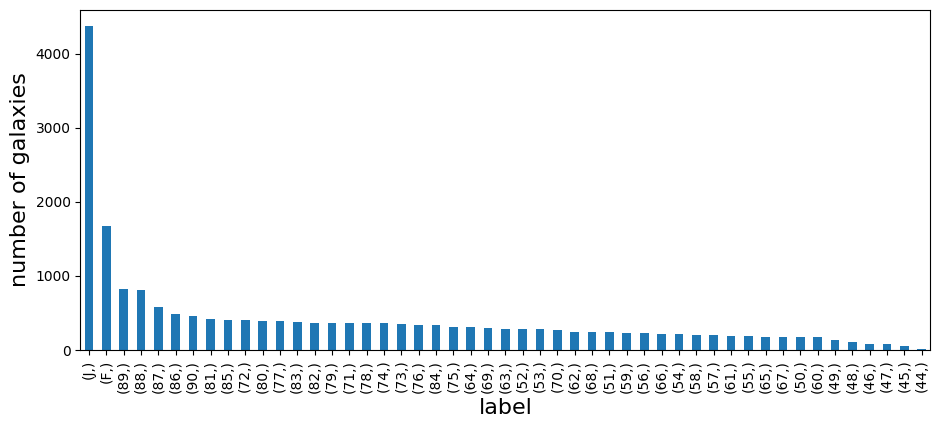

In [11]:
fig = plt.figure(figsize=(10, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

hist = df[["label"]].value_counts().plot(ax=ax, kind='bar')

ax.set_xlabel('label', fontsize=16)
ax.set_ylabel('number of galaxies', fontsize=16)

# Evaluating median inclinations

It is beneficial to evaluate each user evaluations by comparing their results with the median of the inclinations measured by all users. To do so, for a given user we construct a data-frame that consists only the measurements of that particular user. Then we join the table of medians, `df`, with `df_user` and make comparison plots.

In [12]:
def make_user_measurements(email):
    
    df_user = df_All[df_All.email==email]
    df_user = df_user[["pgcID", "inc"]].groupby('pgcID').agg('median').rename(columns={"inc":"inc_user"})
    df_user_all = df_user.join(df, how='left').dropna()
    df_user_all = df_user_all[((df_user_all.label!='F') & (df_user_all.label!='J') & (df_user_all.inc_user>=45))]
    
    return df_user_all

In [13]:
email = 'ekourkchi@gmail.com'
df_user_all = make_user_measurements(email)
df_user_all.head()

,inc_user,inclination,status,label
pgcID,,,,
2,52.5,52.5,A,52
4,86.0,85.5,A,85
12,81.5,81.5,A,81
16,64.5,65.5,A,65
18,50.5,47.0,A,47


### Comparing user's versus everybody's results

In [14]:
## A fucntion to add tickmarks to all axes of the plotting area
################################################################# 
def add_axis(ax, xlim, ylim):
    
    x1, x2 = xlim[0], xlim[1]
    y1, y2 = ylim[0], ylim[1]
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

    ax.minorticks_on()
    ax.tick_params(which='major', length=7, width=1.0)
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0)     
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(2))
    
    # additional Y-axis (on the right)
    y_ax = ax.twinx()
    y_ax.set_ylim(y1, y2)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.yaxis.set_major_locator(MultipleLocator(10))
    y_ax.yaxis.set_minor_locator(MultipleLocator(2))
    y_ax.tick_params(which='major', length=7, width=1.0, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    # additional X-axis (on the top)
    x_ax = ax.twiny()
    x_ax.set_xlim(x1, x2)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.xaxis.set_major_locator(MultipleLocator(10))
    x_ax.xaxis.set_minor_locator(MultipleLocator(2))
    x_ax.tick_params(which='major', length=7, width=1.0, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

################################################################# 

In [15]:
def plot_user_versus_all(df_user_all, email):
    
    fig = py.figure(figsize=(7, 5), dpi=100)
    fig.subplots_adjust(hspace=0.15, top=0.95, bottom=0.15, left=0.15, right=0.95)
    ax = fig.add_subplot(111)

    x = df_user_all.inclination.values
    y = df_user_all.inc_user.values


    ax.plot(x, y, 'g.', picker=5, alpha=0.5)   #### 
    
    delta = x-y
    delata = delta[((x<80)&(x>50))]
    delta = delta[np.where(delta<10)]
    std = np.std(delta)
    rms = np.sqrt(np.mean(delta**2))
    ax.text(38,80, r'$\sigma: $'+"%.1f" % (std)+r'$^o$')
    ax.text(38,75, r'$RMS: $'+"%.1f" % (rms)+r'$^o$')

    p1, = ax.plot([0,100], [0,100], color='black', linestyle='-', label="equality")
    p2, = ax.plot([0,100], [5,105], color='b', linestyle=':', label=r'$\pm5^o$')
    ax.plot([0,100], [-5,95], color='b', linestyle=':')
    p3, = ax.plot([0,100], [10,110], color='r', linestyle='--', label=r'$\pm10^o$')
    ax.plot([0,100], [-10,90], color='r', linestyle='--')

    add_axis(ax, [35,100], [35,100])

    ax.set_ylabel(r'$i_{user}$'+'  [deg]', fontsize=16)
    ax.set_xlabel(r'$i_{median}$'+' [deg]', fontsize=16)

    ax.tick_params(which='major', length=7, width=2.0, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    ax.set_title("User Email: " + email, fontsize=10)
    ax.minorticks_on()

    # Legend
    lns = [p1, p2, p3]
    ax.legend(handles=lns, loc=2, fontsize=14)
    
    
    # y: user's measurements
    # x: median measurements
   
    # we first get rid of outliers that are defined those points with more than 10 degrees of discrepancy
    index = ((x<80)&(np.abs(x-y)<10))
    y = y[index]
    x = x[index]
    
    fit  = np.polyfit(y,x, 1, cov=True)
    a=1.* fit[0][0]
    b=1.* fit[0][1]
    cov = fit[1]

    ax.plot([0,100], [-b/a,100./a-b/a], color='brown', linestyle='--')
    
    print ('(a, b) = ', a, b)
    
    ax.text(85,60, r'$a: $'+"%.4f" % (a), color='brown')
    ax.text(85,56, r'$b: $'+"%.4f" % (b), color='brown')
    ax.text(85,52, r'$\sigma_{a}: $'+"%.4f" % np.sqrt(cov[0][0]), color='brown')
    ax.text(85,48, r'$\sigma_{b}: $'+"%.4f" % np.sqrt(cov[1][1]), color='brown')
    ax.text(85,44, r'$C_{ab}: $'+"%.4f" % (cov[0][1]), color='brown')
    
    ax.text(60, 40, r'$i_{adjusted}$'+' = '+r'$a*i_{user}+b$', fontsize=14)

### Adjusting the measured inclinations by users

After a couple experiments, it's evident that some users make more mistakes than the others.

In the following plot, the evaluations of a user is compared to the median of all estimations. Black line shows the locus of equality of the values. Blue and red dotted lines illustrate deviations from equality by +-5 degrees and +-10 degrees, respectively. Green points are the adjusted inclinations reported by the user. Maroon dashed line fits the green points found by minimizing the mean squared of the residuals along the vertical axis.

The measurements of all users are adjusted in a similar fashion. Then, the table of medians is updated and the process iteratively modify the linear-correcting relations, until reaching convergence.

(a, b) =  0.9480491980563927 2.7517226267642343


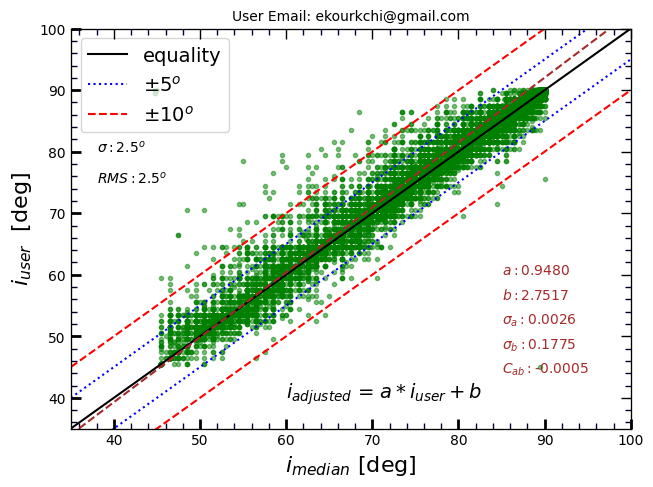

In [16]:
plot_user_versus_all(df_user_all, email)

### Another example

(a, b) =  0.9237110365794249 3.757584728367834


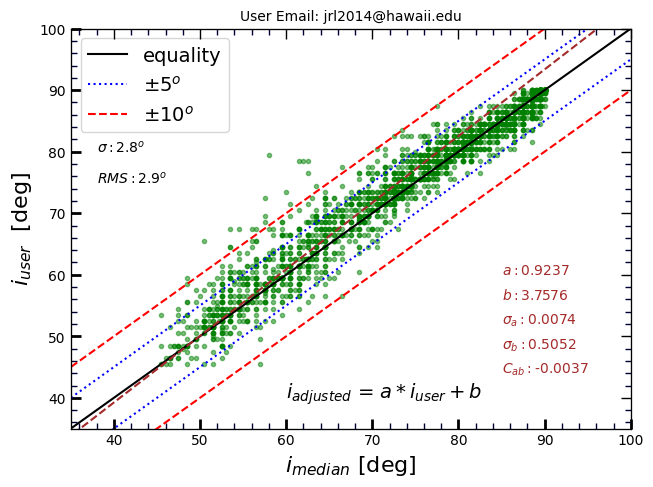

In [17]:
email = 'jrl2014@hawaii.edu'
df_user_all = make_user_measurements(email)

plot_user_versus_all(df_user_all, email)

This process has been completed with the aid of codes available in another repository [here](https://github.com/ekourkchi/HI/tree/master/augment). Please refer to codes whose names start with `test_inclination`

### Adjustment coefficients

Here, we provide the adjustment values in this function that takes the user email address and the measured inclinations and returns the adjusted inclination.

In [18]:
def adjustment(i, email):
    
    a=1
    b=0

    if email=='mka7@hawaii.edu':
        a = 1.0240107102873541
        b = -0.6659991913707819
    if email=='chuangj@hawaii.edu':
        a = 0.9980309937630525
        b = 1.5788591635122715
    if email=='mi24@hawaii.edu':
        a = 1.0072145584376662
        b = 0.6773836673392425
    if email=='s.eftekharzadeh@gmail.com':
        a = 0.9068608738758971
        b = 5.45353754021468
    if email=='arnaud.ohet@gmail.com':
        a = 0.8858412300804692
        b = 8.458077633514366
    if email=='cgrubner0@gmail.com':
        a = 0.8714538061236891
        b = 10.305535769873247
    if email=='pascal.jouve@free.fr':
        a = 1.0278857971914963
        b = -1.089179713885328
    if email=='a.danesh61@gmail.com':
        a = 1.0528898826418465
        b = -4.145783239004519
    if email=='helenecourtois33@gmail.com':
        a = 1.0617630700778644
        b = -1.5237124582869686
    if email=='dschoen@hawaii.edu':
        a = 0.9547149246870876
        b = 2.859742503302656   
    if email=='jrl2014@hawaii.edu':
        a = 0.980285620957423
        b = 0.37282787373070453
    if email=='chasemu@hawaii.edu':
        a = 0.9397141156597442
        b = 4.037537167990864
    if email=='henri140860@wanadoo.fr':
        a = 0.9056035997264794
        b = 6.851826918635101
    if email=='dlsaintsorny@gmail.com':
        a = 0.919185341026506
        b = 5.562153892056073        

    return a*i+b

### Weighting User's measurements based on their performance

We also acknowledge the differences in the users' performances by considering weighted numbers toward the calculation of the median inclinations. We use integer weight numbers that are no greater than 4. We derive weight number in an iterative process based on user experience, the level of needed corrections (according to the slope of the fitted line), and/or the `rms` scatter of differences between raw measurements and the median values.

In the following function, the finalized weight numbers are presented. Since we are taking the median values measured by users, this function simply replicate the evaluated inclinations according to the assigned integer weight number.

In [19]:
def getWeight(inc, email):
    
    n = 0
    if email=='rbtully1@gmail.com': n = 4
    elif email=='rtully@hawaii.edu': n = 4
    elif email=='ekourkchi@gmail.com': n = 3
    elif email=='s.eftekharzadeh@gmail.com':
        if inc>55: n=2
        else: n=0
    elif email=='mokelkea@hawaii.edu': n = 3
    elif email=='chasemu@hawaii.edu': n = 3
    elif email=='jrl2014@hawaii.edu': 
        if inc<85: n=2
        else: n=0
    elif email=='dschoen@hawaii.edu': n = 3
    elif email=='adholtha@hawaii.edu': n = 4
    elif email=='chuangj@hawaii.edu': n = 2
    elif email=='mi24@hawaii.edu': n = 3
    elif email=='mka7@hawaii.edu': n = 2
    elif email=='a.danesh61@gmail.com': n = 2
    
    elif email=='cgrubner0@gmail.com': n = 1
    elif email=='pascal.jouve@free.fr': n = 2
    elif email=='dlsaintsorny@gmail.com': n = 2
    elif email=='arnaud.ohet@gmail.com': n = 1
    elif email=='hawaii@udrea.fr': n = 2
    elif email=='helenecourtois33@gmail.com': n = 2
    elif email=='claude.rene21@gmail.com': n = 1
    elif email=='fredwallet@gmail.com': n = 1
    elif email=='henri140860@wanadoo.fr': n = 1
    elif email=='joannin.lycee@free.fr': n = 2
    elif email=='bevig434@gmail.com': n = 1
    elif email=='pierrefcevey@gmail.com': n = 1
    elif email=='pierre@macweber.ch': n = 1
    elif email=='arnaudoech@gmail.com': n = 1
    elif email=='lionmarm@gmail.com': n = 1
    elif email=='neilljd@gmail.com': n = 3
    elif email=='mseibert@carnegiescience.edu': n = 3
        
    return n 

These customized functions facilitate the weighted aggregation of the adjusted inclination values.

In [20]:
def medianAgg(item):
    
    emails = item[1].email.values
    incs   = item[1].inc.values
    
    inc_weighted = []
    
    for i, inc in enumerate(incs):
        
        email = emails[i]
        w = getWeight(inc, email)
        
        ## here we adjust the user measurement and multiply it by the weight number
        inc_weighted += [adjustment(inc, email)]*w
        
    return np.median(inc_weighted)


def numberAgg(item):
    
    emails = item[1].email.values  
    return len(emails)

In [21]:
group = df_All[["pgcID", "inc", "flag", "face_on", "email"]].groupby('pgcID')

In [22]:
df_weightedMedian = group.agg('median', '')

# adding the weighted medians
df_weightedMedian['weightedINC'] = [medianAgg(item) for item in group]

# adding the number of users measurements
df_weightedMedian['N_measure'] = [numberAgg(item) for item in group]

df_weightedMedian = df_weightedMedian.dropna()

df_weightedMedian.head(25)

/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,inc,flag,face_on,weightedINC,N_measure
pgcID,,,,,
2,52.50,0.0,0.0,52.500000,5
4,85.50,0.0,0.0,84.803864,7
12,81.50,0.0,0.0,81.176421,9
16,65.50,0.0,0.0,65.500000,8
18,47.00,0.0,0.0,47.500000,4
55,78.00,0.0,0.0,77.500000,10
68,55.50,0.0,0.0,55.500000,8
70,90.00,0.0,0.0,90.000000,7
76,68.50,0.0,0.0,68.500000,9


## The statistics of the number of measurements

The initial requirements was to have 3 different measurements by three different users for each galaxy.
However, some of the galaxies have been rejected in the initial work by the project supervisors, R.B.T. and E.K. and therefore they have been removed from the work repository of other users. 

Here, the histogram of all measurements is displayed on the top panel and the orange histogram on the bottom panel shows the number of total measurements of galaxies with accepted inclinations. 

In [23]:
allGals = df_weightedMedian[["N_measure"]]
allAcceptedGals = df_weightedMedian[["N_measure"]][df_weightedMedian.weightedINC>=45]

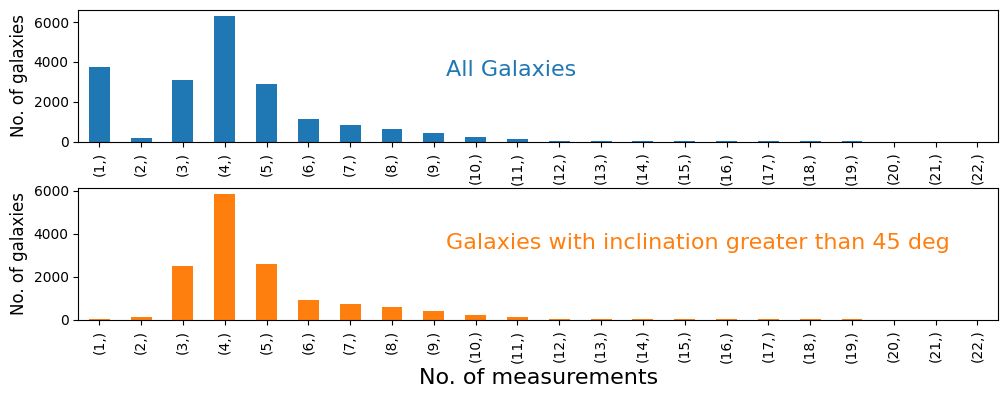

In [24]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

fig = py.figure(figsize=(10,15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(7,1) ; p=0

ax0 = plt.subplot(gs[0])
allGals.value_counts(sort=False).plot(kind='bar', ax=ax0, color=colors[0])

ax1 = plt.subplot(gs[1])
allAcceptedGals.value_counts(sort=False).plot(kind='bar', ax=ax1, color=colors[1])

ax1.set_xlabel('No. of measurements', fontsize=16)
ax0.set_ylabel('No. of galaxies', fontsize=12)
ax1.set_ylabel('No. of galaxies', fontsize=12)


Ylm = ax0.get_ylim() ; Xlm = ax0.get_xlim()
x0 = 0.60*Xlm[0]+0.40*Xlm[1]
y0 = 0.5*Ylm[0]+0.5*Ylm[1]
ax0.text(x0, y0, "All Galaxies", color=colors[0], fontsize=16) 
ax1.text(x0, y0, "Galaxies with inclination greater than 45 deg", color=colors[1], fontsize=16) 

plt.subplots_adjust(hspace=0.35, wspace=0.2)

The following plot exhibits the statistics of the sorted galaxies.
Blue bar represents the total number of candidates in our catalog. Red column shows how many galaxies have at least one measurement. Yellow and green bars display the number of galaxies with at least 2 and 3 measurements, respectively, ans so on.

In [25]:
Na = len(allGals)
N1 = len(allGals[allGals.N_measure>=1])
N2 = len(allGals[allGals.N_measure>=2])
N3 = len(allGals[allGals.N_measure>=3])
N4 = len(allGals[allGals.N_measure>=4])
N5 = len(allGals[allGals.N_measure>=5])

N0 = len(df[((df.label=='F')|(df.label=='J'))])

Text(0, 0.5, 'No. of galaxies')

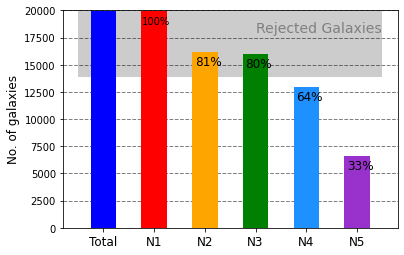

In [26]:
fig, ax = plt.subplots()

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='--', linewidth=1)

ax.add_patch(patches.Rectangle((0.5,Na-N0), 6, N0, color='black', alpha=0.2, linewidth=0))


rects1 = ax.bar([1], [Na], 0.5, color='blue')
rects2 = ax.bar([2], [N1], 0.5, color='red')
rects2 = ax.bar([3], [N2], 0.5, color='orange')
rects2 = ax.bar([4], [N3], 0.5, color='green')
rects2 = ax.bar([5], [N4], 0.5, color='dodgerblue')
rects2 = ax.bar([6], [N5], 0.5, color='darkorchid')

ax.annotate("%d"% (100.*N1/Na)+"%",(1.75,N1-1200), fontsize=10)
ax.annotate("%d"% (100.*N2/Na)+"%",(2.80,N2-1200), fontsize=12)
ax.annotate("%d"% (100.*N3/Na)+"%",(3.80,N3-1200), fontsize=12)
ax.annotate("%d"% (100.*N4/Na)+"%",(4.80,N4-1200), fontsize=12)
ax.annotate("%d"% (100.*N5/Na)+"%",(5.80,N5-1200), fontsize=12)

ax.annotate("Rejected Galaxies",(4, 18000), fontsize=14, color='gray')

ax.tick_params(bottom='off')
#py.setp(ax.get_xticklabels(), visible=False)
ax.set_xticks(range(1,7))
ax.set_xticklabels(['Total','N1','N2','N3', 'N4', 'N5'], fontsize=12)

ax.set_ylim([0, 20000])
ax.set_ylabel("No. of galaxies", fontsize=12)

## Statistical Uncertainty of the Evaluated Uncertainties

Here, we generate the differences between individual evaluated inclinations, `i`, and the median of all measurements, `<i>_median`. 

Below, each blue point represents a single estimated inclination for a galaxy. Red dotted horizontal lines are drawn at the level of +-5 degrees deviations. Red filled circles and their error bars illustrate the median and +-1 sigma standard deviations of the blue points within the 1 degree bins.

### Generating the final inclination table

In [27]:
# Generating the final inclination table

df_weightedMedian['inc'] = df_weightedMedian['weightedINC']
df_final = df_weightedMedian.join(df_super, how='outer')

# Super flag is prefered over median flag that is generated from the work of all users
df_final['flag_final'] = df_final.apply(lambda x: x.flag_super if ~np.isnan(x.flag_super) else x.flag, axis=1)
df_final['face_on_final'] = df_final.apply(lambda x: x.face_on_super if ~np.isnan(x.face_on_super) else x.face_on, axis=1)


df_final = df_final[["inc", "flag_final", "face_on_final"]]

df_final['status'] = 'A'  # accepted

# Face-on
df_final['status'] = df_final.apply(lambda x: 'F' if x.face_on_final==1 else x.status, axis=1) 
# Rejected
df_final['status'] = df_final.apply(lambda x: 'J' if (x.face_on_final==0 and \
                                                      x.flag_final==1) else x.status, axis=1)   


df_final = df_final[["inc", "status"]].rename(columns={'inc':'inclination'})

# Generating claffication labels
# if inc<45 look at the status, if status is already accepted turn it into a rejection, because our online GUI
# has not been designed to sort galaxies with inclinations less than 45 degree
df_final['label'] = df_final.apply(lambda x: str(int(x.inclination)) if round(x.inclination)>=45 else \
                                                      x.status if x.status!='A' else 'J', axis=1)   

# taking care of negative galaxy IDs generated during the development stage of the online GUI and its database
df = df_final[df_final.index>0]   

df.head(10)


# status: (A)accepted (J)rejected (F)face-on
# label: (#)inclination (J)rejected (F)face-on
# inclination: median of all measurments in degrees

,inclination,status,label
pgcID,,,
2,52.500000,A,52
4,84.803864,A,84
12,81.176421,A,81
16,65.500000,A,65
18,47.500000,A,47
55,77.500000,A,77
68,55.500000,A,55
70,90.000000,A,90
76,68.500000,A,68


Here, `df` contains the finalized inclination values. `df_All` holds the original measurements done by user.

We want to know how much mistakes each user makes when measuring the inclinations. We determine this uncertainty value as a function of inclination and for all users. So, a particular user can introduce more uncertainty than the other. The estimations are just the average uncertainty values for all users. 

In [28]:
df_assess = df_All.set_index("pgcID")[["inc", "email"]].join(df, how='left').dropna()

df_assess = df_assess[((df_assess.label!='F')&(df_assess.label!='J')&(df_assess.inc>=45))]

### user measurements - median values
df_assess["inc_med"] = df_assess.inc - df_assess.inclination

df_assess.head()

,inc,email,inclination,status,label,inc_med
pgcID,,,,,,
2,52.5,cgrubner0@gmail.com,52.5,A,52,0.0
2,57.5,pascal.jouve@free.fr,52.5,A,52,5.0
2,51.5,mokelkea@hawaii.edu,52.5,A,52,-1.0
2,52.5,ekourkchi@gmail.com,52.5,A,52,0.0
2,52.5,hawaii@udrea.fr,52.5,A,52,0.0


In agreement with our expectation, the scatter of the users' measurements is small at large inclinations and gradually increases as the inclination angle decreases. For spirals more edge-on than 88 degrees, the user-evaluated inclinations are consistent within 1 degree error bars, whereas for galaxies with inclinations more face-on than 50 degrees, the scatter of the measured inclinations is ~4 degree. 

/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '$inc.-inclination_{median} \\/\\/$[deg]')

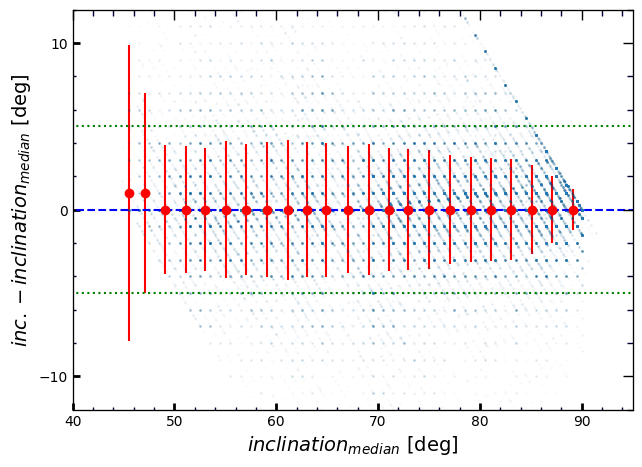

In [29]:
fig = py.figure(figsize=(7, 5), dpi=100)
fig.subplots_adjust(hspace=0.15, top=0.95, bottom=0.15, left=0.15, right=0.95)
ax = fig.add_subplot(111)   


median  = df_assess.inclination
delta   = df_assess.inc_med

ax.plot(median,  delta, '.', ms=2, alpha=0.02)  # alpha=0.3


for incl in np.arange(40,90,2):
    indx = ((median>incl)&(median<=incl+2))
    
    me = median[indx]
    de = delta[indx]
    
    ax.errorbar(np.mean(me), np.median(de), yerr=np.std(de), fmt='o', color='red')


ax.plot([0,100], [0,0], color='b', linestyle='--') 
ax.plot([0,100], [5,5], color='g', linestyle=':')  
ax.plot([0,100], [-5,-5], color='g', linestyle=':')  

xlim=[40,95]
ylim=[-12,12]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
add_axis(ax,xlim,ylim)

ax.tick_params(which='major', length=5, width=2.0, direction='in')
ax.tick_params(which='minor', length=2, color='#000033', width=1.0, direction='in')
ax.minorticks_on()

ax.set_xlabel(r'$inclination_{median} \/\/$[deg]', fontsize=14)
ax.set_ylabel('$inc.-inclination_{median} \/\/$[deg]', fontsize=14)

## Comparin users' asjusted measurements against each other

This comparison is very similar to A/B testing. The only difference here is that we divide users into two different groups, A and B. Then, we build the median tables for these groups and compare the inclination of the common galaxies of both tables. This way, we are able to evaluate the statistical uncertainties on the meausurements. 

In [30]:
A_emails = ['rbtully1@gmail.com', 'mokelkea@hawaii.edu', 'jrl2014@hawaii.edu', 'dschoen@hawaii.edu', 'mi24@hawaii.edu', 'chuangj@hawaii.edu']
B_emails = ['ekourkchi@gmail.com', 's.eftekharzadeh@gmail.com', 'chasemu@hawaii.edu', 'adholtha@hawaii.edu', 'mka7@hawaii.edu', 'a.danesh61@gmail.com', 'helenecourtois33@gmail.com']
C_emails = ['joannin.lycee@free.fr', 'pascal.jouve@free.fr', 'bevig434@gmail.com', 'arnaud.ohet@gmail.com', 'henri140860@wanadoo.fr', 'claude.rene21@gmail.com']
D_emails = ['henri140860@wanadoo.fr', 'hawaii@udrea.fr', 'fredwallet@gmail.com', 'cgrubner0@gmail.com', 'echarraix69@gmail.com', 'dlsaintsorny@gmail.com']
E_emails = ['pierrefcevey@gmail.com','pierre@macweber.ch', 'arnaudoech@gmail.com', 'lionmarm@gmail.com', 'neilljd@gmail.com', 'mseibert@carnegiescience.edu']

groupA_emails = A_emails + C_emails + E_emails
groupB_emails = B_emails + D_emails

print("No. of members in  group A: ", len(groupA_emails))
print("No. of members in  group B: ", len(groupB_emails))

No. of members in  group A:  18
No. of members in  group B:  13


In [31]:
def table4Group(df_All, emailList):
    
    df = df_All[[True if email in emailList else False for email in df_All.email.values]]
    group = df[["pgcID", "inc", "flag", "face_on", "email"]].groupby('pgcID')
    df = group.agg('median', '')
    # adding the weighted medians
    df['weightedINC'] = [medianAgg(item) for item in group]
    # adding the number of users measurements
    df['N_measure'] = [numberAgg(item) for item in group]
    df = df.dropna()
    
    return df

In [32]:
df_A = table4Group(df_All, groupA_emails)
df_A = df_A[["inc", "N_measure"]].rename(columns={'inc':'inc_A', "N_measure":"N_A"})
df_A.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,inc_A,N_A
pgcID,,
2,54.5,2
4,85.5,3
12,80.5,4
16,66.0,2
18,47.0,2


In [33]:
df_B = table4Group(df_All, groupB_emails)
df_B = df_B[["inc", "N_measure"]].rename(columns={'inc':'inc_B', "N_measure":"N_B"})
df_B.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,inc_B,N_B
pgcID,,
2,52.5,3
4,86.0,4
12,81.5,5
16,65.0,6
18,48.5,2


Now we combine both data frames to genrate a single table. We only keep those measurements with more than 2 participants. 

In [34]:
df_AB = df_A.join(df_B, how='left')
df_AB = df_AB[((df_AB.N_A>2)&(df_AB.N_B>2)&(df_AB.inc_A>45)&(df_AB.inc_B>45))]

print("Number of common galaxies with A and B measurements: ", len(df_AB))

df_AB.head()

Number of common galaxies with A and B measurements:  1945


,inc_A,N_A,inc_B,N_B
pgcID,,,,
4,85.5,3,86.0,4.0
12,80.5,4,81.5,5.0
55,78.5,5,77.5,5.0
68,55.5,5,58.5,3.0
70,90.0,4,90.0,3.0


Median of the evaluated inclinations by two different groups of users for ∼2000 galaxies. Each point represents a galaxy with at least three independent measurements by each group. The rms of deviations from equality is 2.6 degrees.

This means that, on average the agreement between two different people about their inclination measurements using our methodology is ~3 degrees. So, probably any machine leaning tool that have almost the similar performance is acceptable.

As expected, we see smaller scatter at larger inclination values towards the edge-on galaxies. Practically, it is much easier for users to recognize and evaluate edge-on galaxies, which fortunately is in the favor of our astronomy research, because our sample mainly consists of edge-on galaxies. On the other hand, more scatter about less inclined galaxies (that indicate larger uncertainty on the measured values) and having much smaller number of evaluated galaxies in that region makes it hard for machine learning algorithms to learn from data and have accurate predictions when galaxies tend to be more face-on (smaller inclination values).

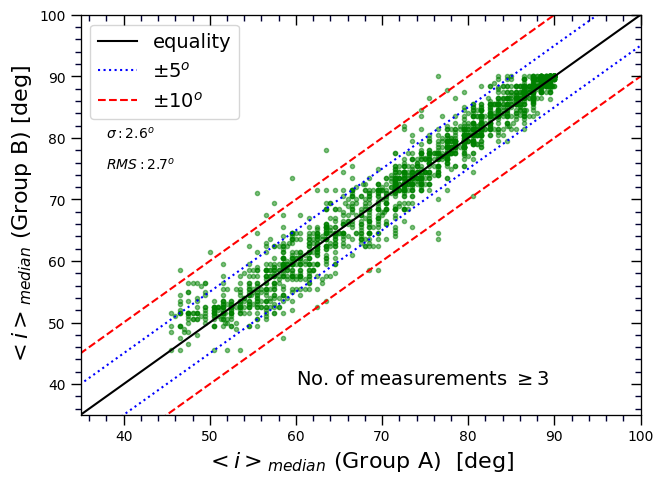

In [35]:
fig = py.figure(figsize=(7, 5), dpi=100)
fig.subplots_adjust(hspace=0.15, top=0.95, bottom=0.15, left=0.15, right=0.95)
ax = fig.add_subplot(111)

x = df_AB.inc_A.values
y = df_AB.inc_B.values


ax.plot(x, y, 'g.', picker=5, alpha=0.5)   #### 

delta = x-y
delata = delta[((x<80)&(x>50))]
delta = delta[np.where(delta<10)]
std = np.std(delta)
rms = np.sqrt(np.mean(delta**2))
ax.text(38,80, r'$\sigma: $'+"%.1f" % (std)+r'$^o$')
ax.text(38,75, r'$RMS: $'+"%.1f" % (rms)+r'$^o$')

p1, = ax.plot([0,100], [0,100], color='black', linestyle='-', label="equality")
p2, = ax.plot([0,100], [5,105], color='b', linestyle=':', label=r'$\pm5^o$')
ax.plot([0,100], [-5,95], color='b', linestyle=':')
p3, = ax.plot([0,100], [10,110], color='r', linestyle='--', label=r'$\pm10^o$')
ax.plot([0,100], [-10,90], color='r', linestyle='--')

add_axis(ax, [35,100], [35,100])

ax.set_xlabel(r'$<i>_{median}$'+' (Group A)  [deg]', fontsize=16)
ax.set_ylabel(r'$<i>_{median}$'+' (Group B) [deg]', fontsize=16)
ax.text(60, 40, 'No. of measurements '+r'$\geq 3$', fontsize=14)

# Legend
lns = [p1, p2, p3]
ax.legend(handles=lns, loc=2, fontsize=14)

## Other evaluations

There are other evaluations that were carried out. For more details please refer to section 2.3 of Kourkchi et al., 2020, ApJ, 902, 145, [arXiv:2009.00733](https://arxiv.org/pdf/2009.00733)).

## Final Catalog

The final catalog of inclinations and other relevant parameters that were produced during this research have been tabulated in table `EDD_distance_cf4_v27.csv` in this repository. [Click here](https://raw.githubusercontent.com/ekourkchi/incNET-data/master/EDD_distance_cf4_v27.csv) to open the table in your browser. Also this catalog is available in the extragalactic distance database [hosted here](https://edd.ifa.hawaii.edu/dfirst.php?) under the **Photometry Section** in the [CF4 Initial Candidates
](https://edd.ifa.hawaii.edu/describe_columns.php?table=kcf4cand) table.

In [36]:
# here is the inclination table we generated in this notebook

df[["label"]].head()

,label
pgcID,
2,52
4,84
12,81
16,65
18,47


In [37]:
df[["label"]].tail()

,label
pgcID,
6719913,J
6724044,F
6724069,51
6724508,58
6726345,F


Comparing above and below tables, you may find very tiny discrepancies. This originates from different ways  that inclinations have been rounded. The way we did round the numbers for the publication is slightly different. Each inclination has been rounded to the next nearest integer value randomly to avoid introducing any additional bias. For instance, 64.5 might have been replaced with either 64 or 65.

In [38]:
# Here is the similar table that was processed for the publication and is officially adopted for this project

table = pd.read_csv('../EDD_distance_cf4_v27.csv', delimiter='|')

## removing the extra spaces in the column names
old_cols = table.columns
new_cols = [item.strip() for item in old_cols]
renameDict = {}
for i, col in enumerate(old_cols):
    renameDict[col] = new_cols[i]
table = table.rename(columns=renameDict)

table.inc_note = [item.strip() for item in table.inc_note.values]

table[["pgc","inc","inc_e","inc_flg","inc_n","inc_note"]].head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,pgc,inc,inc_e,inc_flg,inc_n,inc_note
0,2,52,4,0,5,
1,4,85,2,0,7,
2,12,82,3,0,9,
3,16,65,4,0,8,
4,18,47,6,0,4,


In [39]:
table[["pgc","inc","inc_e","inc_flg","inc_n","inc_note"]].tail()

,pgc,inc,inc_e,inc_flg,inc_n,inc_note
19900,6719913,0,0,1,1,[bad_TF] [disturbed]
19901,6724044,0,0,1,1,[bad_TF] [face_on]
19902,6724069,52,4,0,2,
19903,6724508,60,6,0,5,
19904,6726345,0,0,1,1,[better_image] [ambiguous] [face_on]


## References

- Recovering the Structure and Dynamics of the Local Universe [(Ph.D. Thesis by E. Kourkchi - 2020) ](https://scholarspace.manoa.hawaii.edu/bitstream/10125/68946/Kourkchi_hawii_0085A_10582.pdf)
- Cosmicflows-4: The Catalog of ~10000 Tully-Fisher Distances (**Journal ref:** Kourkchi et al., 2020, ApJ, 902, 145, [arXiv:2009.00733](https://arxiv.org/pdf/2009.00733)) **refer to section 2.3**
- Global Attenuation in Spiral Galaxies in Optical and Infrared Bands (**Journal ref:** Kourkchi et al.,2019, ApJ, 884, 82, [arXiv:1909.01572](https://arxiv.org/pdf/1909.01572)) **refer to section 2.5**
- Galaxy Inclination Zoo [(GIZ)](http://edd.ifa.hawaii.edu/inclination/index.php)
- [GIZ help page](https://edd.ifa.hawaii.edu/inclination/help.html)
- [GIZ Blog](https://galinc.weebly.com/)